# AHU Components

Import all the needed modules

In [1]:
import pandas as pd
from pandas import ExcelWriter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Import sales file

In [2]:
# QV / Sales / Sales_Marketing / Overview / Lines
# Filter by year
sales_file = 'Sales.xlsx'
cols = ['Order no', 'Line no', 'Item no', 'Item name CO',
        'Amount', 'Cost amount', 'CM %', 'Ref order no']
df_sales = pd.read_excel(sales_file, usecols = cols, skiprows = [1])

# Check formats
df_sales['Ref order no'] = df_sales['Ref order no'].astype(str)

# Rename columns
df_sales = df_sales.rename(columns={'Ref order no': 'MO no'})
df_sales.head()

,Order no,Line no,Item no,Item name CO,Amount,Cost amount,CM %,MO no
0,3899063,1,BNBRV,SYSCROLL 200 AIR EVO HP,0.0,18449.790,-,957088
1,4395494,1,B70107,SYSCOIL VC-50-2T (SOLO FRIO),0.0,0.000,-,2096185
2,4519553,1,E5019,Geniox travel kit,844.0,717.400,0.15,
3,4879097,1,BVARIOS,KIT FSC SYSCROLL 540-590,0.0,828.300,-,2317615
4,5034292,1,AHU-GX10C,GX10C,0.0,3918.637,-,1004167542


Import MO's file for the 645-100 work-center and filtered by the period to study (natural year for example)

In [3]:
# QV / Supply / Manufacturing / Reported MO / Mat Transactions
# Filter at "Work Center = 645-100 ASSEMBLY DV" and year
mo_file = '645-100.xlsx'
cols = ['MO no', 'Component no']
df_mo = pd.read_excel(mo_file, usecols = cols, skiprows = [1])

# Check formats
for col in cols:
    df_mo[col] = df_mo[col].astype(str)
    
df_mo.head()

,MO no,Component no
0,1004970908,90925500
1,1004970908,89100
2,1004970908,90715502
3,1004970908,90715101
4,1004970908,89124


Import components file - This data needs to be checked periodically in order to have better stats

In [4]:
# Most important file. Keep it updated with technical office
comp_file = 'Components.xlsx'
df_comp = pd.read_excel(comp_file)
df_comp['Component no'] = df_comp['Component no'].astype(str)
df_comp.head()

,Component no,Description,Component
0,90732769,"ZAbluefin-25-0,50kW",EC-fan
1,2685841,GR28C 0.48kW 2510rpm,EC-fan
2,90732650,GR25C 0.50kW 3080rpm,EC-fan
3,90732770,"ZAbluefin-25-0,78kW",EC-fan
4,2685830,GR25C 0.50kW 3080rpm,EC-fan


Get airflow data from df_sales

In [5]:
airflow_condition = df_sales['Item name CO'].str.contains('Q') & df_sales['Item name CO'].str.contains('=')
df_sales = df_sales.loc[airflow_condition, :]

df_sales['m3/h'] = df_sales['Item name CO'].str.split("=").str[1].str.strip()
df_sales['m3/h'] = df_sales['m3/h'].str.split(" ").str[0]
df_sales['m3/h'] = df_sales['m3/h'].str.lower()
df_sales['m3/h'] = df_sales['m3/h'].str.replace('m3', '').str.strip()
df_sales['m3/h'] = df_sales['m3/h'].str.replace(r'[^0-9]+', '')
df_sales['m3/h'] = df_sales['m3/h'].astype(float)

# Drop column
df_sales.drop(['Item name CO'], axis=1, inplace=True)

Merge MO with Component

In [6]:
df_map = pd.merge(df_mo, df_comp, on='Component no')
df_map.head()

,MO no,Component no,Description,Component
0,1004970908,89100,10-G4-360,Filters
1,1004971180,89100,10-G4-360,Filters
2,1004971442,89100,10-G4-360,Filters
3,1005002759,89100,10-G4-360,Filters
4,1004970908,90715502,Coils,Coils


Get pivot

In [7]:
df_pivot = pd.pivot_table(df_map, values = 'Component no', index = 'MO no',
                          columns = 'Component', aggfunc = 'count')
df_pivot = pd.DataFrame(df_pivot.to_records())

# Create only one check for each component
div = df_pivot.iloc[:, 1:]/df_pivot.iloc[:, 1:]
df_pivot = pd.concat([df_pivot['MO no'], div], axis = 1)
df_pivot = df_pivot.fillna(0)

df_pivot.head()

,MO no,Adiabatic humidifier,Atex,Coils,Compact Filters,Control,Control on/off adiabatic hum.,Control stages adiabatic hum.,Damper,EC-fan,...,Heating Coils,Louver,Metallic roof,Mixing damper,Plate HE,Plug-fan,Rotary HE,Sound attenuator,Steam lance,UV lamp
0,1004689962,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1004835641,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1004835746,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1004840141,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1004908120,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Merge to the final dataframe and remove zero-value rows. Rearrange the columns

In [8]:
df_final = pd.merge(df_sales, df_pivot, on='MO no')
df_final = df_final.fillna(0)
#df_final = df_final[df_final['Order no'] != 0]
df_final.head()

,Order no,Line no,Item no,Amount,Cost amount,CM %,MO no,m3/h,Adiabatic humidifier,Atex,...,Heating Coils,Louver,Metallic roof,Mixing damper,Plate HE,Plug-fan,Rotary HE,Sound attenuator,Steam lance,UV lamp
0,5388305,1,AHU-DV80,16664.69,15945.343,0.043166,1004835746,16920.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5438247,1,AHU-GX20C,16411.00,11308.390,0.310926,1004908120,13675.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,5470849,1,AHU-GX24,16079.61,13730.057,0.146120,1005264166,17848.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,5477812,1,AHU-GX10,3511.00,2667.179,0.240336,1004970908,740.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5478895,1,AHU-GX24C,10497.00,6772.429,0.354822,1004978386,25000.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Export to Excel

In [9]:
name = 'AHU-Components - Results.xlsx'
writer = pd.ExcelWriter(name)
df_final.to_excel(writer, index = False)
writer.save()

Visualizations

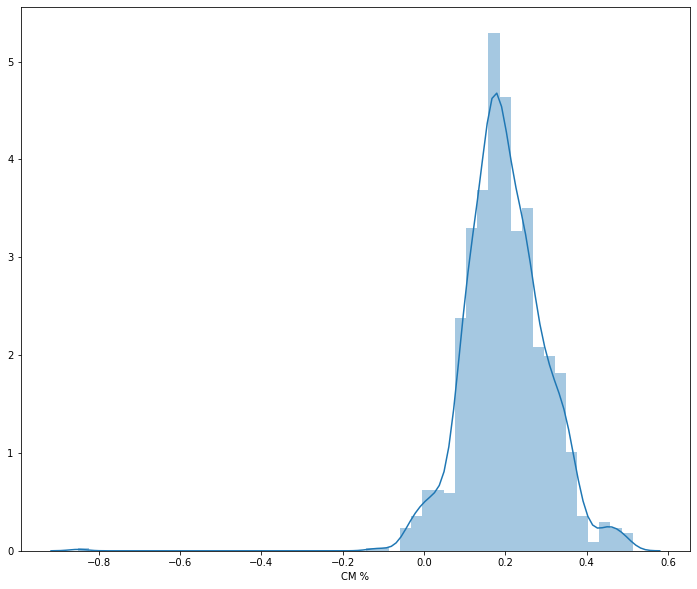

In [14]:
plt.figure(figsize=(12,10))
# Features to analyze
columns = list(df_pivot.columns.values)[1:]
sns.distplot(df_final['CM %'])

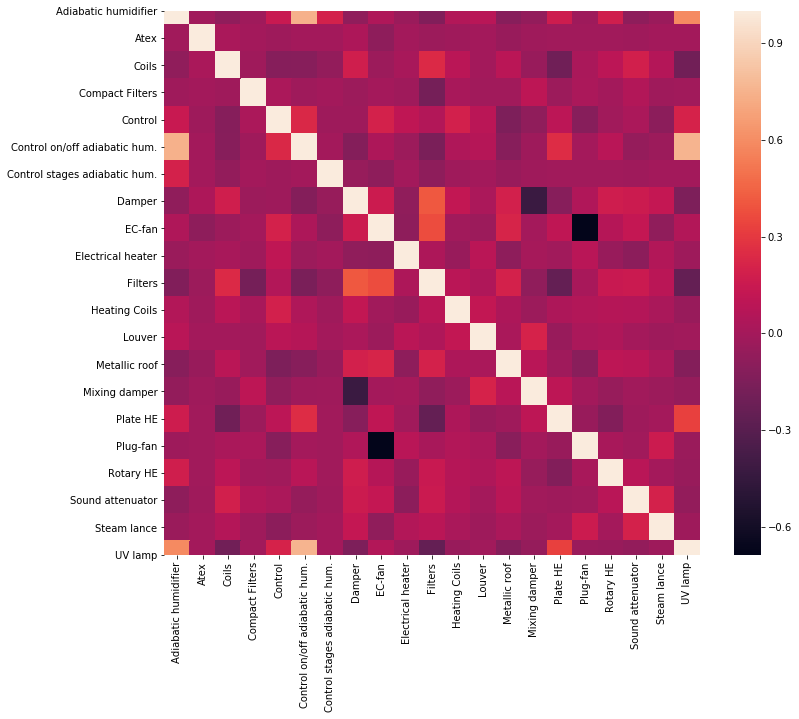

In [48]:
# Calculate correlations
corr = df_final[columns].corr()
 
# Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr)

<Figure size 864x720 with 0 Axes>

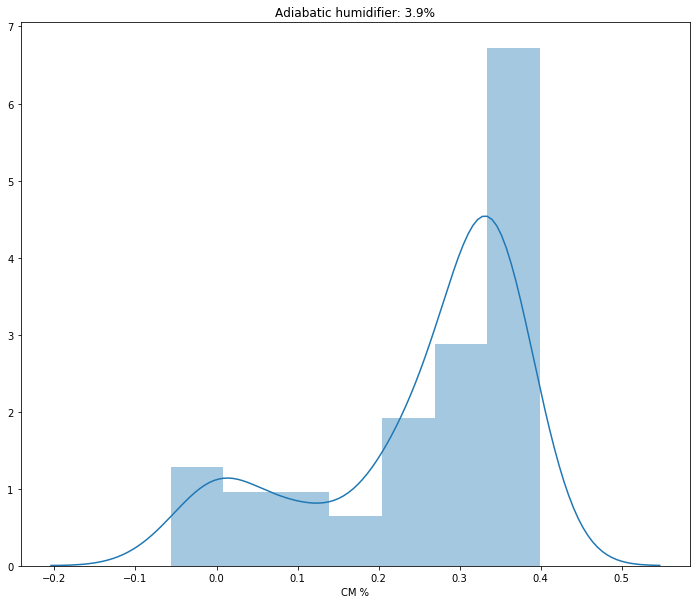

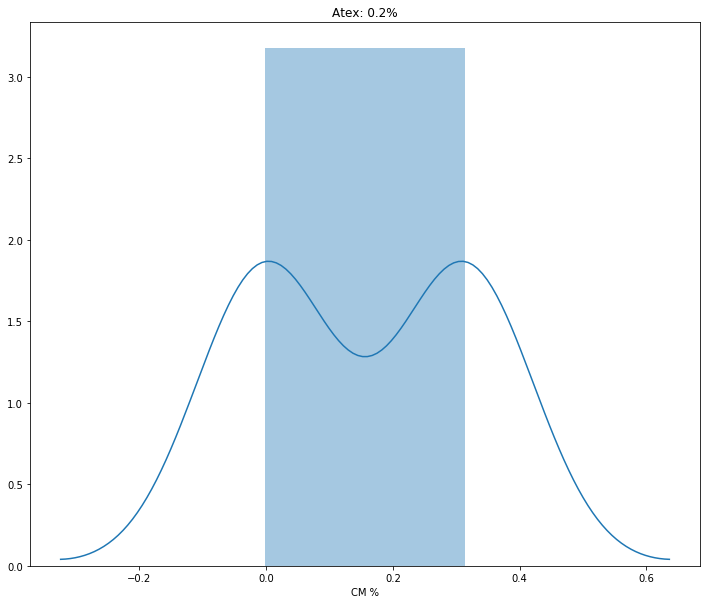

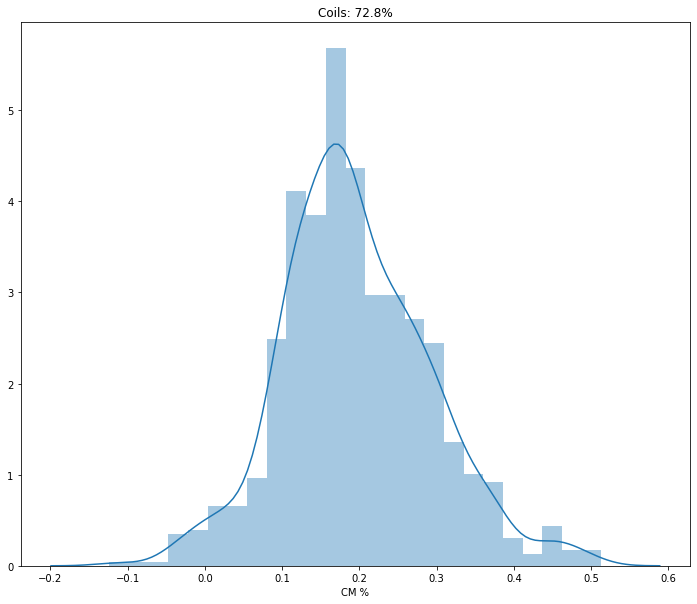

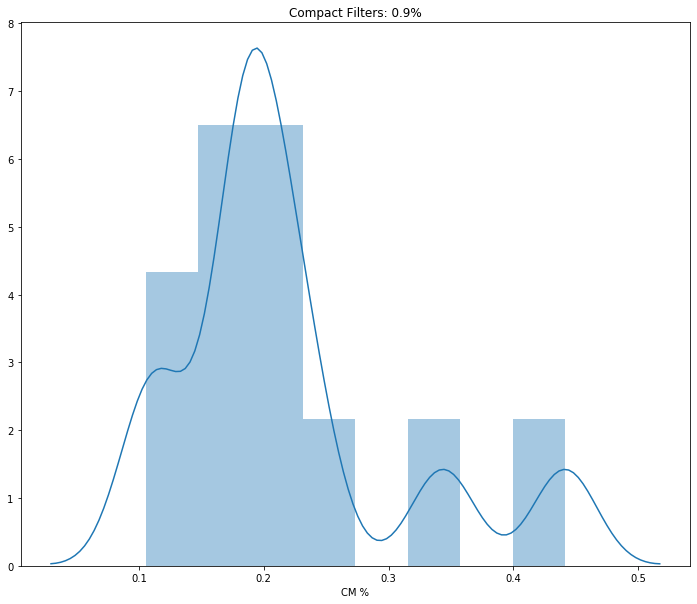

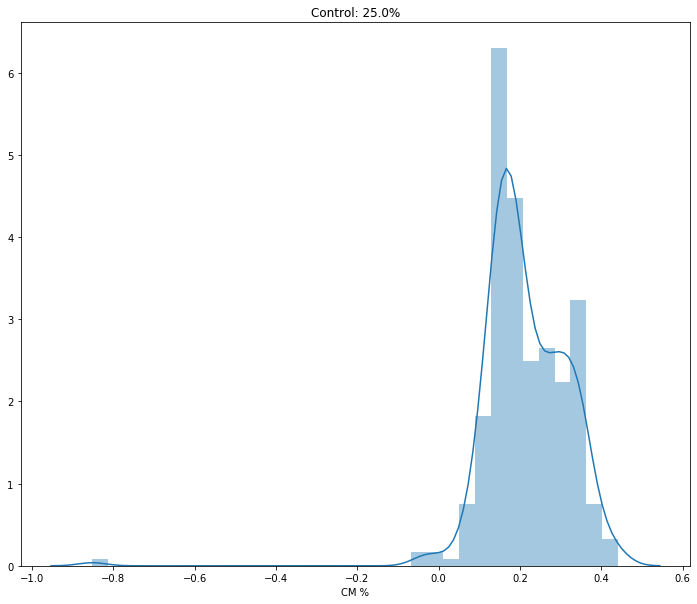

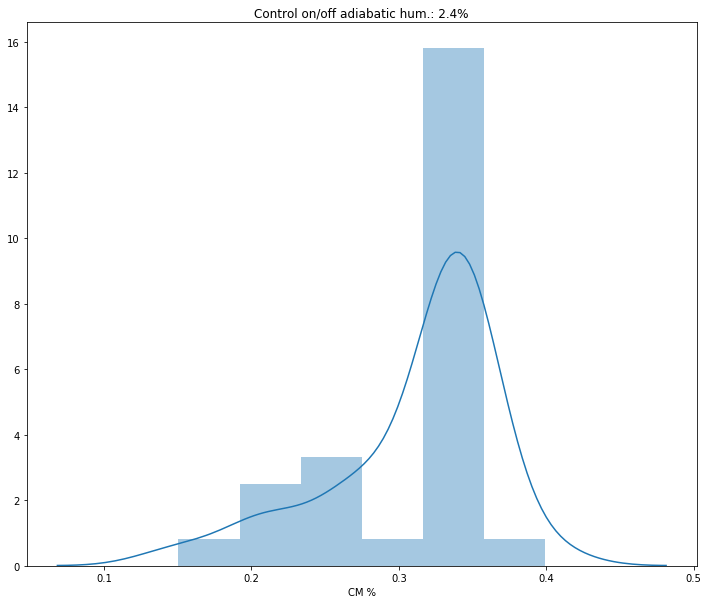

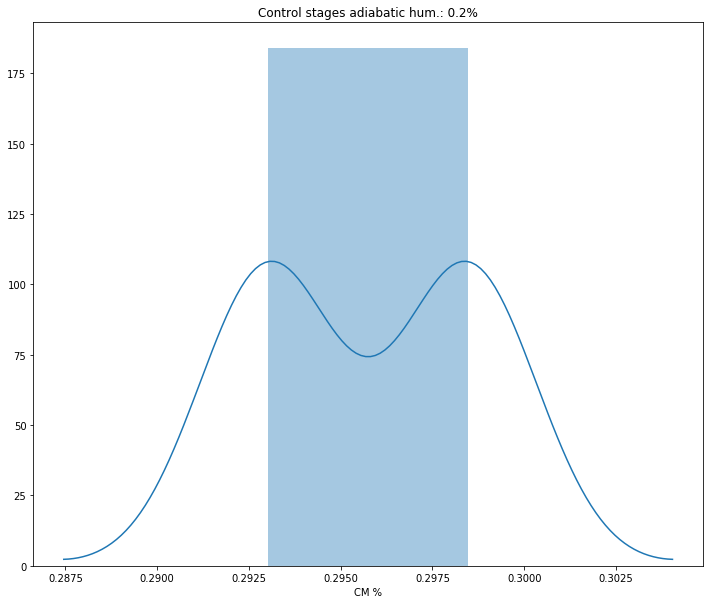

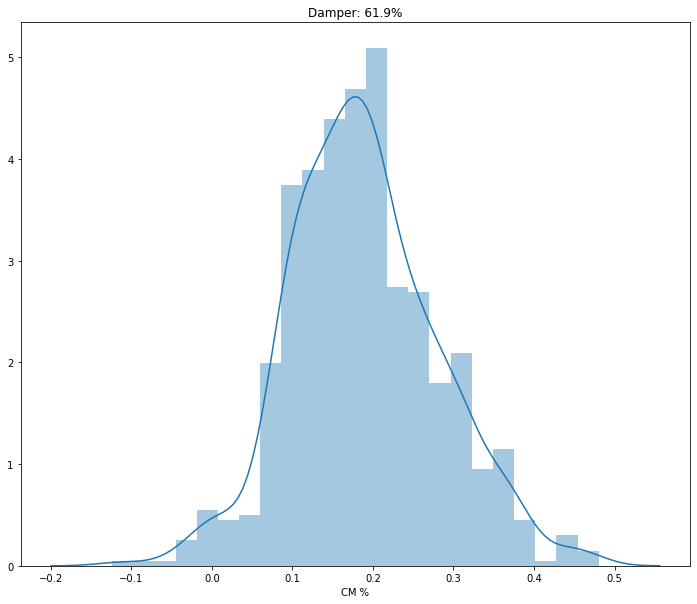

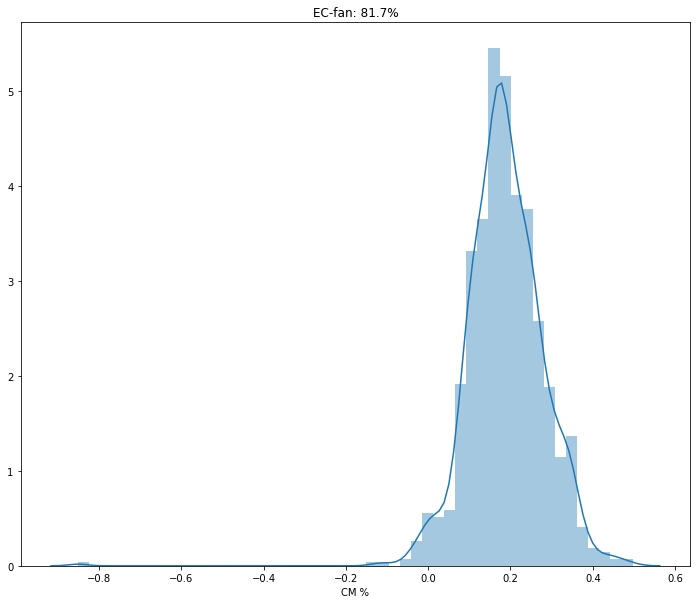

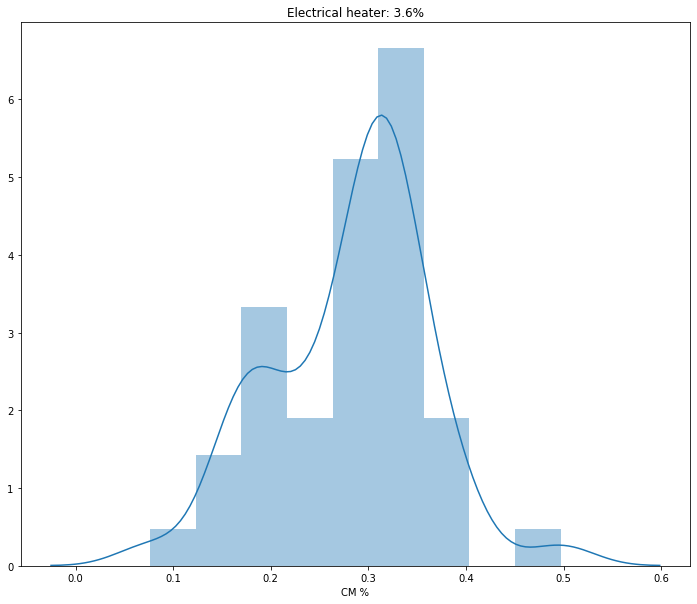

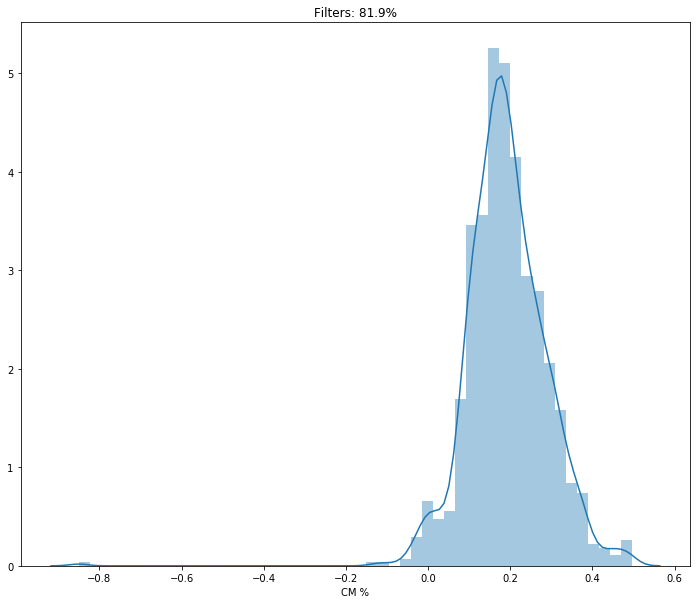

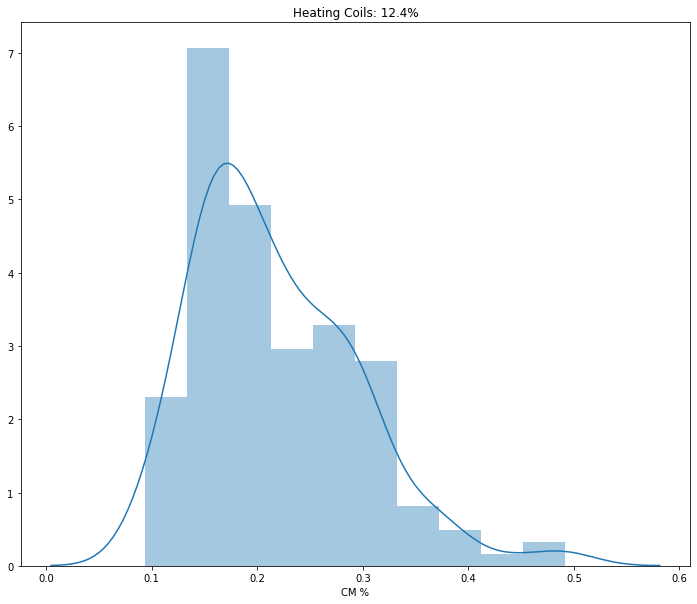

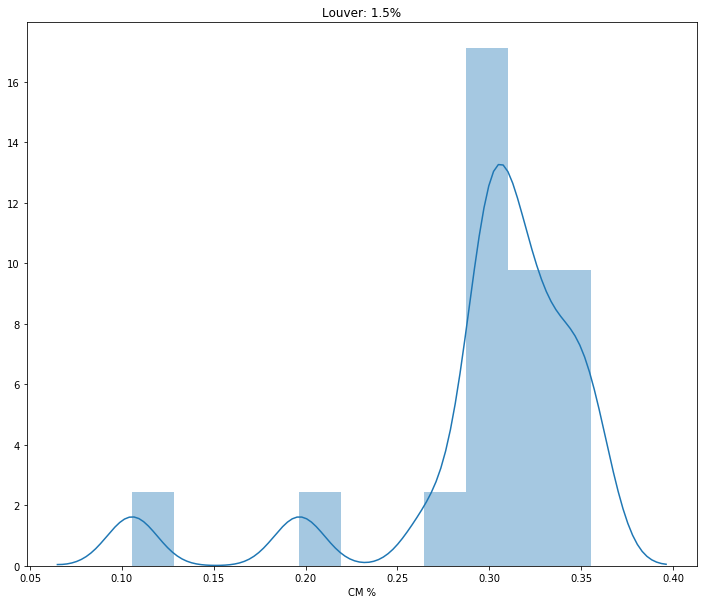

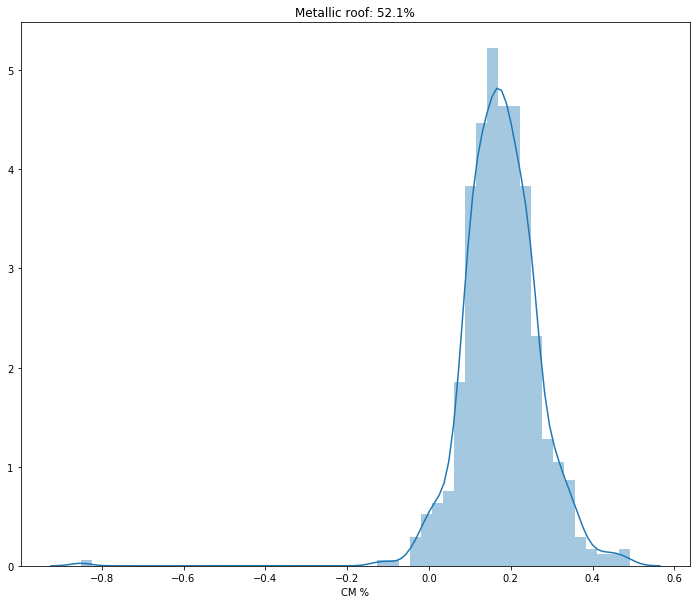

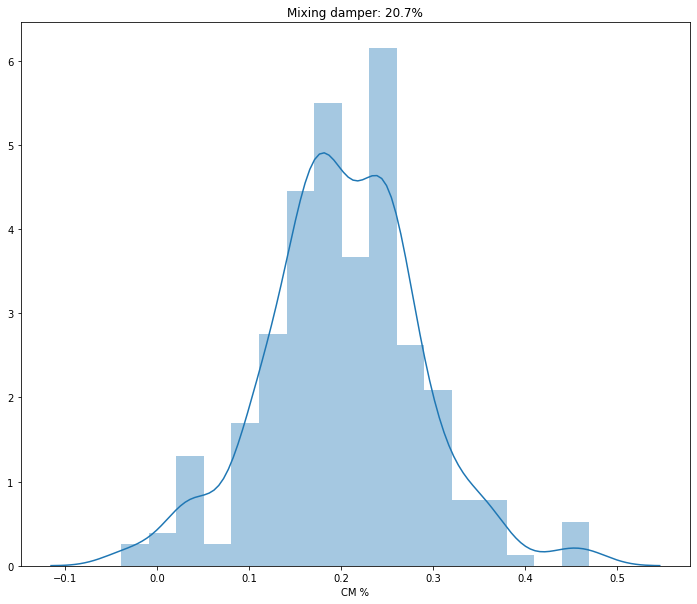

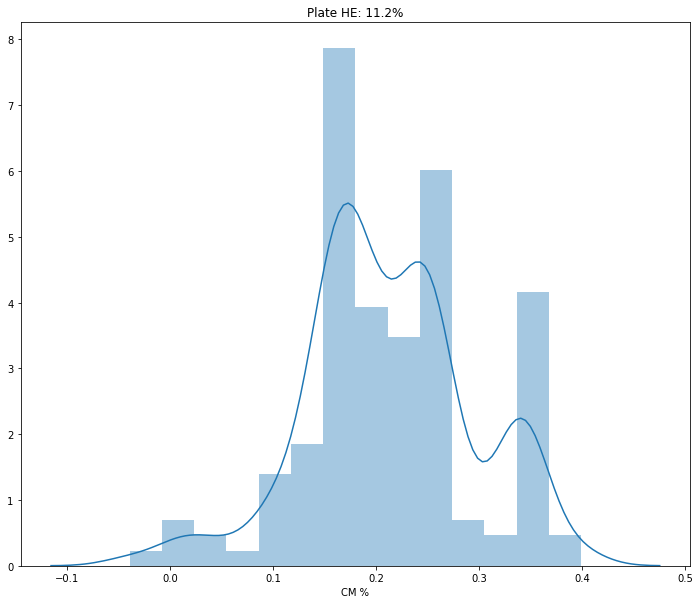

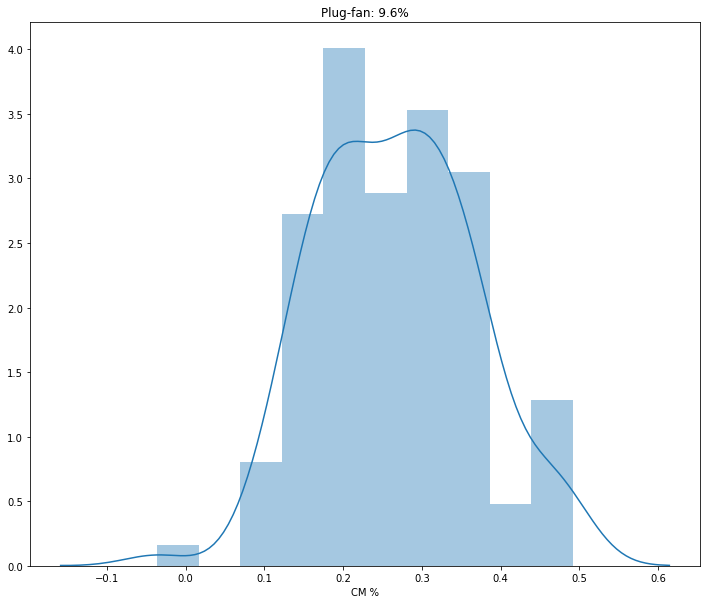

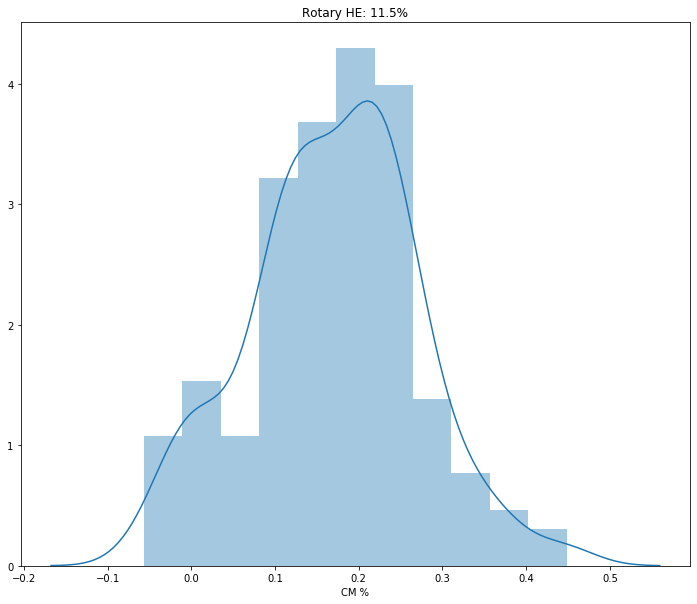

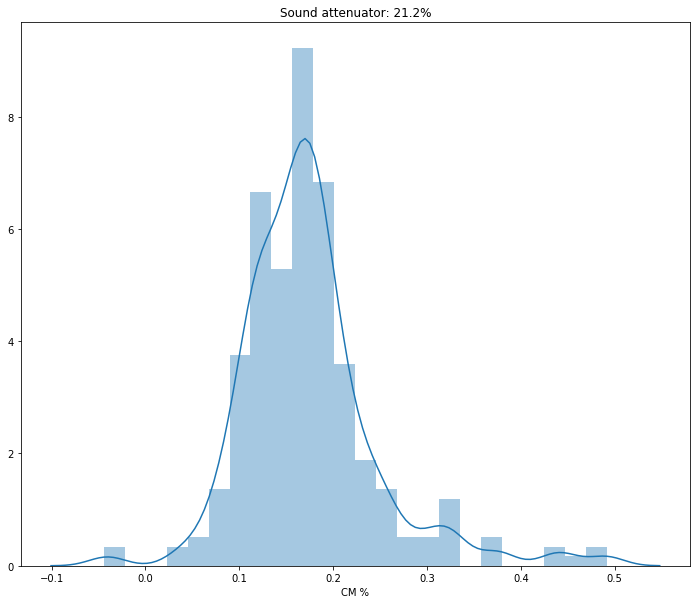

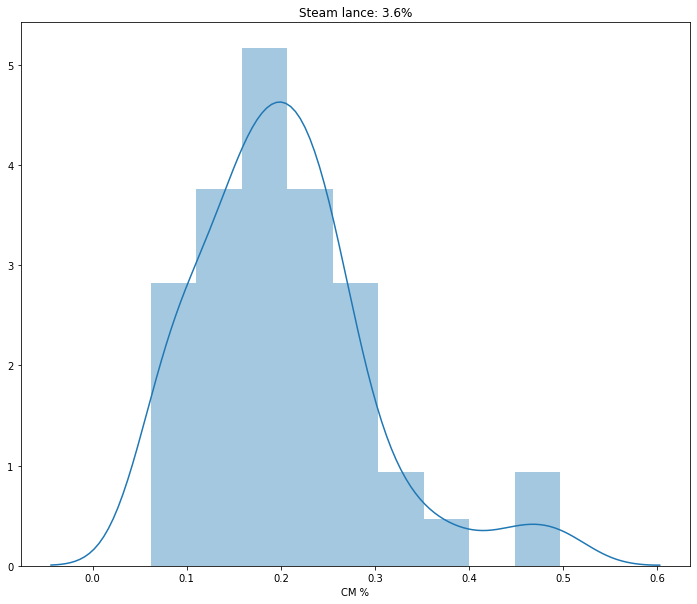

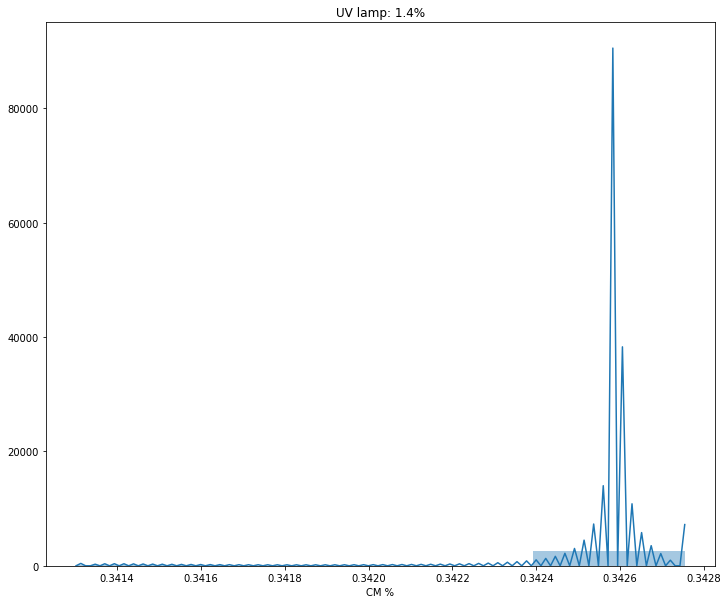

In [45]:
plt.figure(figsize=(12,10))
total = len(df_final['MO no'])

for column in columns:
    plt.figure(figsize=(12,10))
    df_plot = df_final.loc[df_final[column] == 1,'CM %']
    feature_count = len(df_plot)    
    sns.distplot(df_plot)
    #df_plot.hist()
    ratio = 100*feature_count/total
    t = f"{column}: {ratio:.1f}%"
    plt.title(t)
    plt.show()